# MCNN - PyTorch Implementation
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchmetrics

from model import *
# from transforms import Identity, MovingAvg, Downsample
from dataloader import TS_dataset

## Data
Using the `ECG5000` dataset for testing. Information can be found [here](https://timeseriesclassification.com/description.php?Dataset=ECG5000).

In [2]:
dataset = 'ECG5000'

Train: (500, 141)
Test: (4500, 141)


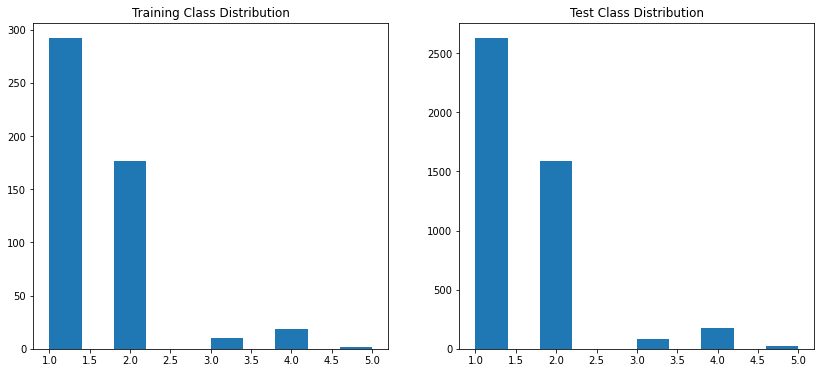

In [3]:
train_data = np.loadtxt('./data/' + dataset + '/' + dataset + '_TRAIN.txt')
test_data = np.loadtxt('./data/' + dataset + '/' + dataset + '_TEST.txt')

print("Train:", train_data.shape)
print("Test:", test_data.shape)

Y_train = train_data[:, 0]
Y_test = test_data[:, 0]

n_classes = len(np.unique(Y_train))

plt.subplots(1,2,figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(Y_train)
plt.title('Training Class Distribution')
plt.subplot(1,2,2)
plt.hist(Y_test)
plt.title('Test Class Distribution')
plt.show()

Reshape for `PyTorch` to have $(n, c, l)$ with $n$ being the number of samples, $c$ being the number of channels, which is one for this univariate dataset, and $l$ being the length, using the `ECG5000` dataloader.

In [4]:
train_dataset = TS_dataset(train_data)
test_dataset = TS_dataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

## Model
Creating a single model without applying grid search.

In [5]:
transformations = {
    'identity': {
        'class': Identity,
        'params': []
    },
    'movingAvg': {
        'class': MovingAvg,
        'params': [3, 4, 5]       # window sizes
    },
    'downsample': {
        'class': Downsample,
        'params': [2, 3]       # sampling rates
    }
}

ts_length = train_dataset.X.shape[-1]
ts_shape = (train_dataset.X.shape[-2], train_dataset.X.shape[-1])
pool_factor = 4
kernel_size = int(ts_length*0.05)

model = MCNN(ts_shape, n_classes, pool_factor, kernel_size, transformations)


model = model.cuda()
optim = torch.optim.Adam(model.parameters())

print(model)


MCNN(
  (branches): ModuleList(
    (0): Sequential(
      (identity_transform): Identity()
      (identity_conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=same)
      (identity_activation): ReLU()
      (identity_pool): MaxPool1d(kernel_size=35, stride=35, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (movingAvg_3_transform): MovingAvg()
      (movingAvg_3_conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=same)
      (movingAvg_3_activation): ReLU()
      (movingAvg_3_pool): MaxPool1d(kernel_size=34, stride=34, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (movingAvg_4_transform): MovingAvg()
      (movingAvg_4_conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=same)
      (movingAvg_4_activation): ReLU()
      (movingAvg_4_pool): MaxPool1d(kernel_size=34, stride=34, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (movingAvg_5_transform): MovingAvg()
      (movingAvg_5_conv): 

## Training

In [8]:
EPOCHS = 4

results = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
 
    # training
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()
        yhat = model.forward(x)
        loss = torch.nn.CrossEntropyLoss()(yhat, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_losses.append(loss.item())
        acc = torchmetrics.functional.accuracy(yhat, y.int())
        epoch_accuracies.append(acc)

    epoch_loss = torch.mean(epoch_losses)
    epoch_acc = torch.mean(epoch_accuracies)

    # validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.cuda()
            y = y.cuda()
            yhat = model.forward(x)
            loss = torch.nn.CrossEntropyLoss()(yhat, y)
            epoch_val_losses.append(loss.item())
            acc = torchmetrics.functional.accuracy(yhat, y.int())
            epoch_val_accuracies.append(acc)

    epoch_val_loss = torch.mean(epoch_val_losses)
    epoch_val_acc = torch.mean(epoch_val_accuracies)

    # populate results
    results['loss'].append( epoch_loss )
    results['val_loss'].append( epoch_val_loss )
    results['acc'].append( epoch_acc )
    results['val_acc'].append( epoch_val_acc )

    #if (epoch+1) % 5 == 0 or epoch+1 == EPOCHS:
    print("Epoch {}/{}\tTrain Loss: {:.4f}\tTest Loss: {:.4f}\tTrain Accuracy: {:.2f}%\tTest Accuracy: {:.2f}%".format(
            epoch+1, EPOCHS, epoch_loss, epoch_val_loss, epoch_acc*100, epoch_val_acc*100) )

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [14]:
model.branches[1]

Sequential(
  (movingAvg_3_transform): MovingAvg()
  (movingAvg_3_conv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=same)
  (movingAvg_3_activation): ReLU()
  (movingAvg_3_pool): MaxPool1d(kernel_size=34, stride=34, padding=0, dilation=1, ceil_mode=False)
)

## Results

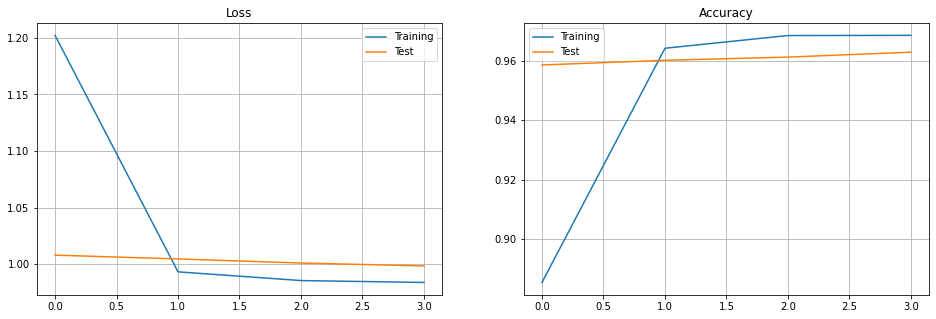

In [10]:
plt.subplots(1, 2, figsize=(16, 5))

plt.subplot(121)
plt.plot(results['loss'], label='Training')
plt.plot(results['val_loss'], label='Test')
plt.grid('on')
plt.legend()
plt.title('Loss')

plt.subplot(122)
plt.plot(results['acc'], label='Training')
plt.plot(results['val_acc'], label='Test')
plt.grid('on')
plt.legend()
plt.title('Accuracy')

plt.show()

---